In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#this one is erroring, so make a robust scaler from scratch
#from sklearn.preprocessing import RobustScaler
import statistics
plt.style.use("bmh")
from datetime import timedelta
import ta

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


In [2]:
df = pd.read_csv("SPY.csv")

In [3]:
#datetime conversion
df['Date'] = pd.to_datetime(df.Date)

#set the index
df.set_index('Date', inplace=True)

#drop nans
df.dropna(inplace = True)

In [4]:
df = ta.add_all_ta_features(df, open="Open", high = "High", low = "Low", close = "Close", volume = "Volume", fillna=True)

#drop everything besides "Close" and indicators
#df.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace=True)
#onyl keep close
df.drop(df.columns.difference(['Close']), 1, inplace=True)

C:\Users\Shaq\Anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Shaq\Anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [5]:
#just use the last 1000 days to get a more recent representation
#df is days X metric
df = df.tail(1000)
df.tail()

,Close
Date,
2021-03-15,396.410004
2021-03-16,395.910004
2021-03-17,397.260010
2021-03-18,391.480011
2021-03-19,389.480011


In [6]:
#scale fit the data
#robustScaler scales data according to Quartile rage
# so it's not sensitive to outliers

#IMPLEMENT A ROBUST SCALER
#y = (xi - med)/(IQR3-IQR1)
med = pd.DataFrame.median(df)

IQR3= df.quantile(.75, axis=0)
IQR1 = df.quantile(.25, axis=0)
IQR = IQR3 - IQR1

In [7]:
#normalize the data
#scaler = RobustScaler()
#df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

df = (df-med)/(IQR)
df.tail()

,Close
Date,
2021-03-15,1.015090
2021-03-16,1.006367
2021-03-17,1.029917
2021-03-18,0.929089
2021-03-19,0.894200


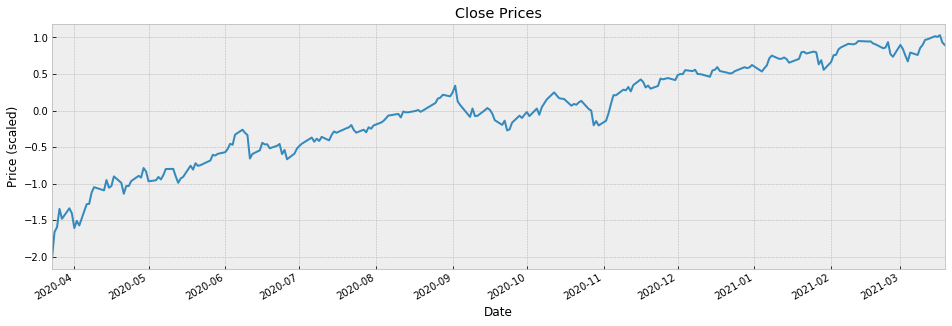

In [8]:
#plot the close prices
df['Close'].plot(figsize=(16,5))
plt.title("Close Prices")
plt.ylabel("Price (scaled)")
plt.show()

In [9]:
#TO PREPARE DATA FOR LSTM
def split_sequence(seq, n_steps_in, n_steps_out):
    
    #create a list for both variables
    X,y = [], []
    
    for i in range(len(seq)):
        
        #find the end of the current sequence
        end = i + n_steps_in         #input data
        out_end = end + n_steps_out  #prediction data
        
        #break if eaxeeded dataset's length
        if out_end > len(seq):
            break
            
            
        #Splitting sequence into: x = pastprices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)  # these are just the close prices
    return np.array(X), np.array(y)

In [11]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    #create topology for RNN
    #adds a dropout for each hidden layer
    
    #create N hidden layers with M nodes
    for x in range(1, n_layers+1):
        model.add(LSTM(n_nodes, activation = activation, return_sequences = True))
        
        #add a dropout layer 
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [21]:
#SPLIT THE DATA

#data in
n_per_in = 90

#data points to predict
n_per_out = 30

#features
n_features = df.shape[1]

#split the data into sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [30]:
#create the NN
model = Sequential()

#activation
activ = "tanh"

#input layer
model.add(LSTM(90, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

#hidden layers
layer_maker(n_layers=2, n_nodes=30, activation=activ, drop=1, d_rate=0.1)

#final hidden layer
model.add(Dense(n_per_out))

#model summary
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x0000000037877548>>

In [31]:
#compile the model
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
print(X.shape)
print(y.shape)
print(type(X))
print(type(y))

(132, 90)
(132, 30)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [32]:
#fitting and trainign
res = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/100


ValueError: in user code:

    C:\Users\Shaq\Anaconda3\lib\site-packages\keras\engine\training.py:830 train_function  *
        return step_function(self, iterator)
    C:\Users\Shaq\Anaconda3\lib\site-packages\keras\engine\training.py:813 run_step  *
        outputs = model.train_step(data)
    C:\Users\Shaq\Anaconda3\lib\site-packages\keras\engine\training.py:770 train_step  *
        y_pred = self(x, training=True)
    C:\Users\Shaq\Anaconda3\lib\site-packages\keras\engine\base_layer.py:989 __call__  *
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\Shaq\Anaconda3\lib\site-packages\keras\engine\input_spec.py:212 assert_input_compatibility  *
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 90)


In [ ]:
#SKIP VALIDATION FOR NOW

In [ ]:
#PREDICT/FORECAST PRICES
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

#inverse robust scaler
yhat = (yhat*IQR) + med
df = (df*IQR) + med

#to store the values
predictions = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1]+timedelta(days=1),
                                                          periods=len(yhat),
                                                          freq="B"),
                                                columns=[df.columns[0]])

#num of periods in reverse to plot actual values
periods = n_per_in

#DF of actual data
pd.DataFrame(df, index=df.Close.index, columns=[df.columns[0]]).append(predictions.head(1))


#plot
plt.figure(figsize=(16,6))
plt.plot(actual, label="actual prices")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()